In [10]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [11]:
# Load the dataset
df = pd.read_csv('Mall_Customers.csv')

# Display shape and first few rows
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (200, 5)

First 5 rows:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Missing values:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [12]:
# Select features for clustering
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled data to DataFrame for clarity
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
print("\nScaled features (first 5 rows):")
print(X_scaled_df.head())


Scaled features (first 5 rows):
        Age  Annual Income (k$)  Spending Score (1-100)
0 -1.424569           -1.738999               -0.434801
1 -1.281035           -1.738999                1.195704
2 -1.352802           -1.700830               -1.715913
3 -1.137502           -1.700830                1.040418
4 -0.563369           -1.662660               -0.395980


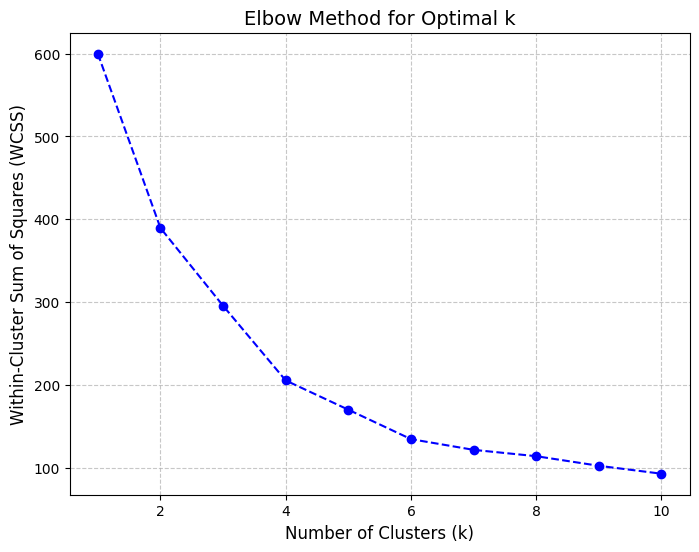

In [13]:
# Calculate WCSS for different numbers of clusters
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [14]:
# Fit K-means with optimal k (assume k=5 based on typical Elbow results)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Add cluster labels to DataFrame
print("\nData with cluster labels (first 5 rows):")
print(df.head())

# Display cluster centroids (unscaled)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=features)
print("\nCluster centroids (original scale):")
print(centroids_df)


Data with cluster labels (first 5 rows):
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

   Cluster  
0        2  
1        2  
2        3  
3        2  
4        2  

Cluster centroids (original scale):
         Age  Annual Income (k$)  Spending Score (1-100)
0  55.275862           47.620690               41.706897
1  32.875000           86.100000               81.525000
2  25.769231           26.115385               74.846154
3  26.733333           54.311111               40.911111
4  44.387097           89.774194               18.483871


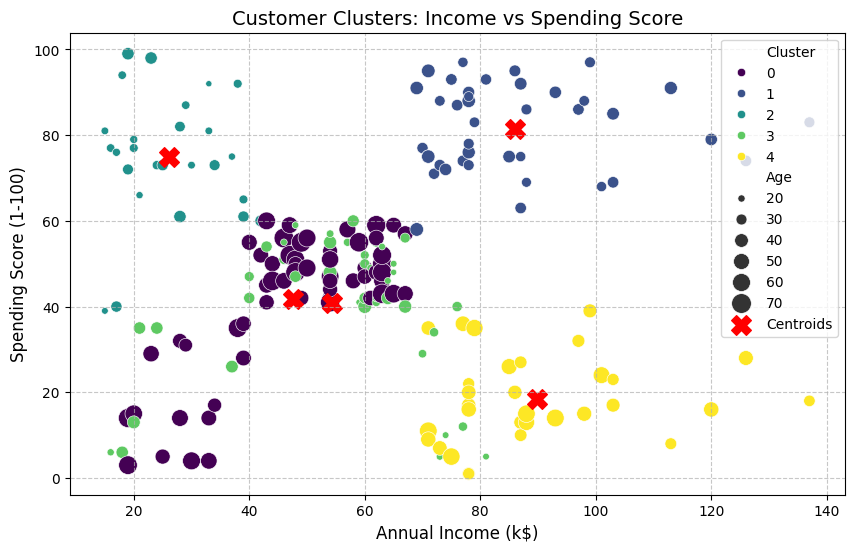

In [15]:
# 2D scatter plot: Annual Income vs Spending Score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster',
                size='Age', sizes=(20, 200), palette='viridis', data=df)
plt.scatter(centroids[:, 1], centroids[:, 2], s=200, c='red', marker='X', label='Centroids')
plt.title('Customer Clusters: Income vs Spending Score', fontsize=14)
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

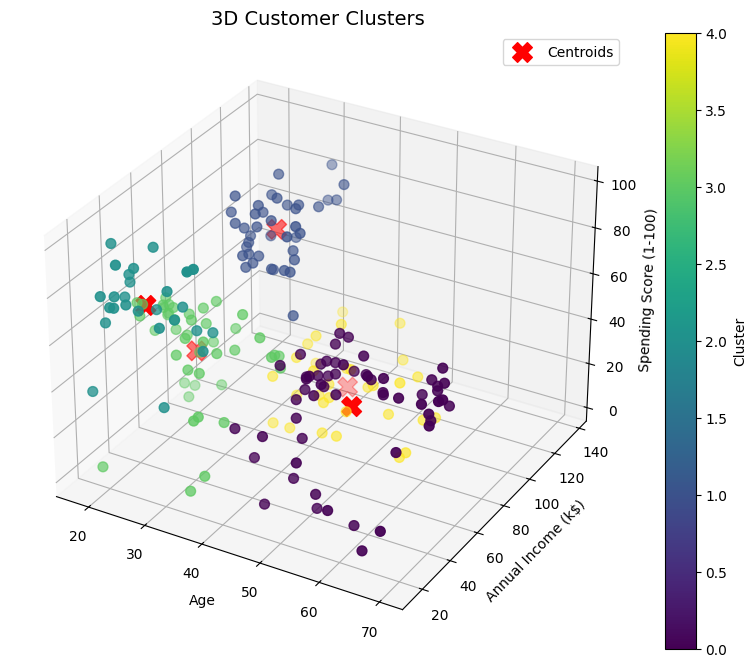

In [16]:
# 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['Age'], df['Annual Income (k$)'], df['Spending Score (1-100)'],
                     c=df['Cluster'], cmap='viridis', s=50)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], s=200, c='red', marker='X', label='Centroids')
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
plt.title('3D Customer Clusters', fontsize=14)
plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.show()

In [17]:
# Define spending score ranges (0-10, 11-20, ..., 91-100)
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
df['Spending Range'] = pd.cut(df['Spending Score (1-100)'], bins=bins, labels=labels, include_lowest=True)

# Summarize by spending score range
summary = df.groupby('Spending Range').agg({
    'Age': 'mean',
    'Annual Income (k$)': 'mean',
    'Gender': lambda x: x.mode()[0] if not x.empty else 'N/A',  # Most common gender
    'CustomerID': 'count'  # Count of customers in each range
}).rename(columns={'CustomerID': 'Count'})

# Round numeric values for clarity
summary['Age'] = summary['Age'].round(1)
summary['Annual Income (k$)'] = summary['Annual Income (k$)'].round(1)

# Fill any empty ranges with placeholder values
summary = summary.reindex(labels, fill_value={'Age': 0, 'Annual Income (k$)': 0, 'Gender': 'N/A', 'Count': 0})

# Display formatted summary
print("\nCustomer Analysis by Spending Score Range:")
print("=" * 50)
print(summary)
print("=" * 50)

# Interpret results
print("\nInterpretation of Spending Score Ranges:")
for range_label in labels:
    if summary.loc[range_label, 'Count'] > 0:
        print(f"\nSpending Score {range_label}:")
        print(f"- Average Age: {summary.loc[range_label, 'Age']:.1f} years")
        print(f"- Average Annual Income: ${summary.loc[range_label, 'Annual Income (k$)']:.1f}k")
        print(f"- Most Common Gender: {summary.loc[range_label, 'Gender']}")
        print(f"- Number of Customers: {summary.loc[range_label, 'Count']}")
    else:
        print(f"\nSpending Score {range_label}: No customers in this range.")


Customer Analysis by Spending Score Range:
                 Age  Annual Income (k$)  Gender  Count
Spending Range                                         
0-10            39.0                59.0    Male     16
11-20           47.1                71.8    Male     20
21-30           41.3                74.9  Female     10
31-40           39.6                53.5  Female     17
41-50           44.0                55.4  Female     40
51-60           42.7                53.7  Female     35
61-70           28.6                63.2    Male      8
71-80           29.8                58.4  Female     24
81-90           29.8                73.9  Female     16
91-100          31.6                63.5    Male     14

Interpretation of Spending Score Ranges:

Spending Score 0-10:
- Average Age: 39.0 years
- Average Annual Income: $59.0k
- Most Common Gender: Male
- Number of Customers: 16

Spending Score 11-20:
- Average Age: 47.1 years
- Average Annual Income: $71.8k
- Most Common Gender: Male
-

/tmp/ipython-input-17-277304912.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby('Spending Range').agg({
